In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading Images

In [2]:
img_dir = "../../02_data/img_small"

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    validation_split=0.2,
    subset="training",
    seed = 123,
    image_size=(400, 400),
    batch_size=8
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    validation_split=0.2,
    subset="validation",
    seed = 123,
    image_size=(400, 400),
    batch_size=8
)



Found 278 files belonging to 4 classes.
Using 223 files for training.
Found 278 files belonging to 4 classes.
Using 55 files for validation.


In [4]:
class_names = train_ds.class_names
img_height = img_width = 400
print(class_names) # We can modify the labels by changing the name of corresponding folders

['0', '1', '2', '3']


## Standarize data (Data normalization)

In [5]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.78823537


## Model

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [7]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(400, 400, 3)),
    layers.Conv2D(16, 3, padding='same', activation='gelu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='gelu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='gelu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='gelu'),
    layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                  

In [10]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
28/28 [==============================] - 4s 42ms/step - loss: 1.2168 - accuracy: 0.4439 - val_loss: 0.8860 - val_accuracy: 0.5818
Epoch 2/10
28/28 [==============================] - 1s 32ms/step - loss: 0.8501 - accuracy: 0.6009 - val_loss: 0.3716 - val_accuracy: 0.9091
Epoch 3/10
28/28 [==============================] - 1s 31ms/step - loss: 0.5404 - accuracy: 0.8251 - val_loss: 0.2260 - val_accuracy: 0.9455
Epoch 4/10
28/28 [==============================] - 1s 31ms/step - loss: 0.3117 - accuracy: 0.9013 - val_loss: 0.2696 - val_accuracy: 0.8909
Epoch 5/10
28/28 [==============================] - 1s 31ms/step - loss: 0.2013 - accuracy: 0.9283 - val_loss: 0.0714 - val_accuracy: 0.9818
Epoch 6/10
28/28 [==============================] - 1s 31ms/step - loss: 0.0847 - accuracy: 0.9776 - val_loss: 0.0757 - val_accuracy: 0.9818
Epoch 7/10
28/28 [==============================] - 1s 32ms/step - loss: 0.3456 - accuracy: 0.8834 - val_loss: 0.2124 - val_accuracy: 0.8909
Epoch 8/10
28

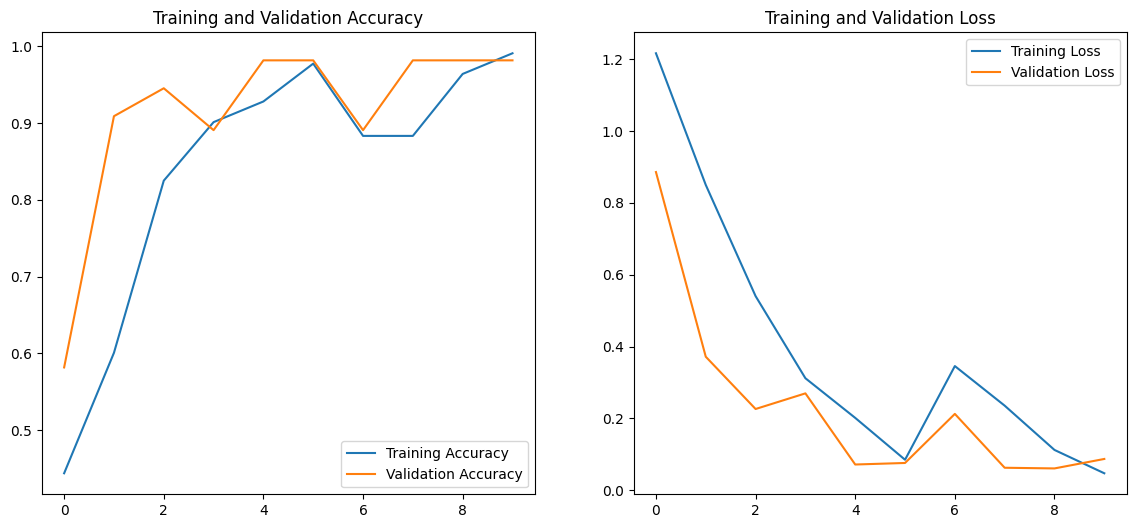

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Convert the model to Tensorflow Lite

In [12]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ots01\AppData\Local\Temp\tmp5zseot_i\assets


INFO:tensorflow:Assets written to: C:\Users\ots01\AppData\Local\Temp\tmp5zseot_i\assets
